# Binary Classification

In [2]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_subreddits_dataset.csv')

In [4]:
df.dropna(axis = 0, how = 'any')

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,-0.6652
1,967,anxiety,1635203988,Currently 8 and a half months pregnant and als...,-0.8555
2,1142,anxiety,1635203613,Few people had COVID in my building and refuse...,-0.2960
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,0.7626
4,1616,depression,1635202459,This hits close to home. \n\nHe sounds similar...,-0.4006
...,...,...,...,...,...
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531
45882,17777197,mentalhealth,1581454025,"Hi mate, as someone with GAD I can relate to y...",0.5332


In [8]:
df.at[45880, 'body']

'Stay focused on what the experts are saying and avoid the sensationalized click bait.\n\nI think we can safely say at this point, that contracting the Covid-19 virus would be a complete non-event for the average, otherwise healthy individual.'

In [3]:
df.tail()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531
45882,17777197,mentalhealth,1581454025,"Hi mate, as someone with GAD I can relate to y...",0.5332
45883,17777368,anxiety,1581071322,***MORE UPDATES ON MY OTHER COMMENT ON THIS T...,0.9325


In [5]:
import re #regex library used for substituting words
import demoji #https://github.com/bsolomon1124/demoji
# demoji.download_codes()

In [6]:
def pre_cleaning(text):
    line=re.sub(r"\Bu/\w+", "USERNAME", text) #replace username with USERNAME
    line = demoji.replace(line, repl=' ')
    return line

In [7]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [9]:
#above functions combined
def preprocessing(text):
    line = pre_cleaning(text)
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [10]:
df.body = df.body.apply(lambda x: preprocessing(x))

### Anxiety SVM

In [11]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'anxiety':
        drop_list.append(a)

In [12]:
anxiety_sample = df.drop(drop_list, axis = 0)
anxiety_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
1,967,anxiety,1635203988,currently half months pregnant also covid suff...,-0.8555
2,1142,anxiety,1635203613,people covid building refused get vaccinated,-0.2960
7,5439,anxiety,1635193321,surrounded anti covid vax people mine also sec...,-0.9364
8,5753,anxiety,1635192653,wow found sub reddit today really ever reddit ...,-0.9878
12,7513,anxiety,1635188671,fine study results shown amp plus moderna comb...,0.9834
...,...,...,...,...,...
45878,17777040,anxiety,1581474617,interesting indeed also interesting much menta...,0.9428
45879,17777050,anxiety,1581473713,quite interesting terms somewhat putting thing...,-0.9256
45880,17777094,anxiety,1581466598,stay focused experts saying avoid sensationali...,0.7430
45881,17777113,anxiety,1581463547,new covid cases c confirmed patients well prov...,-0.1531


In [13]:
for sentiment in anxiety_sample['sentiment']:
    anxiety_sample['sentiment'].replace({sentiment : 'anxiety'}, inplace=True)

In [14]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'anxiety':
        control_list.append(a)

In [19]:
anxiety_control = df.drop(control_list, axis = 0)
anxiety_control = anxiety_control.sample(16689)
anxiety_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
21690,10588883,suicidewatch,1605974727,huh see okay feel way good someone life make s...,0.9794
6317,3925243,covid19_support,1626527115,unlikely impossible terms long covid virus get...,-0.7684
18203,9307965,covid19_support,1609360743,whole family gone since covid far planning,0.0000
9557,5599591,covid19_support,1620458129,went worrying high risk parents kept checking ...,0.9628
22967,11049139,depression,1604808188,generally tried connecting people classes get ...,-0.7208
...,...,...,...,...,...
2848,1897626,covid19_support,1630639480,yep thing happened sis fully vaccinated caught...,0.2960
29670,13242589,covid19_support,1598049117,know feel mourning life covid,-0.4404
2756,1826372,covid19_support,1630779425,hate agree covidiot husband anything test woul...,0.9636
12464,6981685,suicidewatch,1616304975,yes diagnosed adhd recently able get treated d...,-0.8969


In [20]:
for sentiment in anxiety_control['sentiment']:
    anxiety_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [17]:
anxiety_dataset = pd.concat([anxiety_sample, anxiety_control])
anxiety_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
1,967,anxiety,1635203988,currently half months pregnant also covid suff...,anxiety
2,1142,anxiety,1635203613,people covid building refused get vaccinated,anxiety
7,5439,anxiety,1635193321,surrounded anti covid vax people mine also sec...,anxiety
8,5753,anxiety,1635192653,wow found sub reddit today really ever reddit ...,anxiety
12,7513,anxiety,1635188671,fine study results shown amp plus moderna comb...,anxiety
...,...,...,...,...,...
5510,3413526,covid19_support,1627753110,still possibility catch covid less severe prob...,control
42478,16725260,depression,1586756648,jesus mean may cake help attracted compulsive ...,control
24010,11466594,covid19_support,1603645200,also wisconsin sympathize level anxiety talkin...,control
26990,12488733,depression,1600548422,think manage never home alone covid always som...,control


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(anxiety_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 26702
Test Data size 6676


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [26]:
print("anxiety_train Shape:",x_train.shape)
print("anxiety_test Shape:",x_test.shape)

anxiety_train Shape: (26702, 11309)
anxiety_test Shape: (6676, 11309)


In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (26702, 1)
y_test shape: (6676, 1)


In [74]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics

In [30]:
# Perform classification with SVM, kernel=linear
anxiety_classifier = svm.SVC(kernel='linear')
t0 = time.time()
anxiety_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = anxiety_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'anxiety']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('anxiety: ', report['anxiety'])

Training time: 347.813413s; Prediction time: 40.399346s
Accuracy: 0.7778609946075494
control:  {'precision': 0.814, 'recall': 0.7252747252747253, 'f1-score': 0.7670802575781372, 'support': 3367}
anxiety:  {'precision': 0.7483677910772579, 'recall': 0.8313689936536718, 'f1-score': 0.7876879026485326, 'support': 3309}


### Depression SVM

In [122]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'depression':
        drop_list.append(a)

In [123]:
depression_sample = df.drop(drop_list, axis = 0)
depression_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
4,1616,depression,1635202459,hits close home sounds similar pour insight th...,-0.4006
6,5124,depression,1635194028,sorry dog amp going parents also think covid h...,-0.6387
43,25236,depression,1635130949,hey man care feel dealing since 17 sucks days ...,-0.3371
44,25409,depression,1635130321,everything life moving forward need surrounded...,0.4323
63,37410,depression,1635096893,makes basically like nasty cold get covid vacc...,-0.5106
...,...,...,...,...,...
45591,17714315,depression,1583509183,hospital crowded covid panic missing hour gues...,-0.5719
45654,17730423,depression,1583294463,first confirmed case covid state today low key...,-0.9345
45655,17730635,depression,1583291007,covid coming worries bro,0.3252
45779,17766846,depression,1582518347,advice talk recruiter biochem degree probably ...,0.0000


In [124]:
for sentiment in depression_sample['sentiment']:
    depression_sample['sentiment'].replace({sentiment : 'depression'}, inplace=True)

In [125]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'depression':
        control_list.append(a)

In [126]:
depression_control = df.drop(control_list, axis = 0)
depression_control = depression_control.sample(5871)
depression_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
39305,15886687,covid19_support,1589571109,precise issue lockdowns need balance physical ...,-0.9175
14059,7705921,covid19_support,1613985345,sorry took context edit wrong quote quotes pro...,0.2641
1331,780634,anxiety,1633008857,years old friend died like months ago heart d...,0.9537
37874,15489690,anxiety,1591040940,hi taylor really hope boat suffered anxiety pa...,0.8873
36854,15244661,anxiety,1591988143,post removed flagged see mentioned covid pleas...,0.7827
...,...,...,...,...,...
28647,12962374,anxiety,1598986081,post removed flagged see mentioned covid pleas...,0.7635
6816,4224357,covid19_support,1625522744,possible unlikely forget million diseases simi...,-0.0387
36632,15195600,covid19_support,1592207095,reason risk takeaway changed restaurant open e...,-0.8735
31317,13686368,covid19_support,1596681951,wow thank struggling somewhat also chalked sla...,0.9437


In [127]:
for sentiment in depression_control['sentiment']:
    depression_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [128]:
depression_dataset = pd.concat([depression_sample, depression_control])
depression_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
4,1616,depression,1635202459,hits close home sounds similar pour insight th...,depression
6,5124,depression,1635194028,sorry dog amp going parents also think covid h...,depression
43,25236,depression,1635130949,hey man care feel dealing since 17 sucks days ...,depression
44,25409,depression,1635130321,everything life moving forward need surrounded...,depression
63,37410,depression,1635096893,makes basically like nasty cold get covid vacc...,depression
...,...,...,...,...,...
28647,12962374,anxiety,1598986081,post removed flagged see mentioned covid pleas...,control
6816,4224357,covid19_support,1625522744,possible unlikely forget million diseases simi...,control
36632,15195600,covid19_support,1592207095,reason risk takeaway changed restaurant open e...,control
31317,13686368,covid19_support,1596681951,wow thank struggling somewhat also chalked sla...,control


In [129]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(depression_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 9393
Test Data size 2349


In [130]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [131]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (9393, 6538)
x_test Shape: (2349, 6538)


In [132]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (9393, 1)
y_test shape: (2349, 1)


In [133]:
# Perform classification with SVM, kernel=linear
depression_classifier = svm.SVC(kernel='linear')
t0 = time.time()
depression_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = depression_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'depression']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('depression: ', report['depression'])

Training time: 20.313354s; Prediction time: 3.909336s
Accuracy: 0.7684120902511707
control:  {'precision': 0.8013698630136986, 'recall': 0.7060344827586207, 'f1-score': 0.7506874427131072, 'support': 1160}
depression:  {'precision': 0.7430293896006028, 'recall': 0.8292682926829268, 'f1-score': 0.7837837837837839, 'support': 1189}


### MentalHealth SVM

In [135]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'mentalhealth':
        drop_list.append(a)

In [136]:
mentalhealth_sample = df.drop(drop_list, axis = 0)
mentalhealth_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
9,6594,mentalhealth,1635190779,covid girlfriend home day everyday driving cra...,0.1615
13,8232,mentalhealth,1635187037,like company made us work home soon someone ho...,0.7631
27,13991,mentalhealth,1635174447,sound egotistical used problem probably start ...,0.8508
29,16648,mentalhealth,1635167578,really good age accept decision enjoy time gu...,0.9847
31,16902,mentalhealth,1635166737,hey sorry going tough time think us feel like ...,0.9747
...,...,...,...,...,...
45301,17612619,mentalhealth,1584120252,right worry worried husband psych nurse scares...,-0.9284
45323,17622751,mentalhealth,1584086361,watch tv search covid info online,0.0000
45331,17624677,mentalhealth,1584077134,sorry hear anxieties acting much right opposit...,-0.9574
45441,17670621,mentalhealth,1583895477,need worry take action worry assuming based po...,0.9730


In [137]:
for sentiment in mentalhealth_sample['sentiment']:
    mentalhealth_sample['sentiment'].replace({sentiment : 'mentalhealth'}, inplace=True)

In [138]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'mentalhealth':
        control_list.append(a)

In [139]:
mentalhealth_control = df.drop(control_list, axis = 0)
mentalhealth_control = mentalhealth_control.sample(3307)
mentalhealth_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
13792,7603397,suicidewatch,1614298126,hey bro got get scary seems like dumpster fire...,0.9725
17861,9174732,covid19_support,1609700454,thanks helpful remember study saw one covid19 ...,0.7500
26467,12337906,covid19_support,1601064534,sorry going may solution definitely feel famil...,-0.8946
33682,14347808,anxiety,1594846931,researchers say abbvie tricor reduced severity...,0.3724
40039,16091845,anxiety,1588870311,looks like mentioned covid post please take lo...,0.8434
...,...,...,...,...,...
26859,12450325,covid19_support,1600702979,much hate feeling time stood still significant...,0.8357
14594,7903999,depression,1613331523,sucks honestly part hating never relationship ...,-0.8442
2686,1789778,covid19_support,1630863935,mom also like degree allow meet friends vaccin...,0.9759
39388,15910298,covid19_support,1589493205,covid lethal led believe,0.0000


In [140]:
for sentiment in mentalhealth_control['sentiment']:
    mentalhealth_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [141]:
mentalhealth_dataset = pd.concat([mentalhealth_sample, mentalhealth_control])
mentalhealth_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
9,6594,mentalhealth,1635190779,covid girlfriend home day everyday driving cra...,mentalhealth
13,8232,mentalhealth,1635187037,like company made us work home soon someone ho...,mentalhealth
27,13991,mentalhealth,1635174447,sound egotistical used problem probably start ...,mentalhealth
29,16648,mentalhealth,1635167578,really good age accept decision enjoy time gu...,mentalhealth
31,16902,mentalhealth,1635166737,hey sorry going tough time think us feel like ...,mentalhealth
...,...,...,...,...,...
26859,12450325,covid19_support,1600702979,much hate feeling time stood still significant...,control
14594,7903999,depression,1613331523,sucks honestly part hating never relationship ...,control
2686,1789778,covid19_support,1630863935,mom also like degree allow meet friends vaccin...,control
39388,15910298,covid19_support,1589493205,covid lethal led believe,control


In [142]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(mentalhealth_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 5291
Test Data size 1323


In [143]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [144]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (5291, 5213)
x_test Shape: (1323, 5213)


In [145]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (5291, 1)
y_test shape: (1323, 1)


In [146]:
# Perform classification with SVM, kernel=linear
mentalhealth_classifier = svm.SVC(kernel='linear')
t0 = time.time()
mentalhealth_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = mentalhealth_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'mentalhealth']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('mentalhealth: ', report['mentalhealth'])

Training time: 7.812565s; Prediction time: 1.690650s
Accuracy: 0.7241118669690099
control:  {'precision': 0.7334437086092715, 'recall': 0.6846986089644513, 'f1-score': 0.7082334132693845, 'support': 647}
mentalhealth:  {'precision': 0.7162726008344924, 'recall': 0.7618343195266272, 'f1-score': 0.7383512544802867, 'support': 676}


### SuicideWatch SVM

In [148]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'suicidewatch':
        drop_list.append(a)

In [149]:
SuicideWatch_sample = df.drop(drop_list, axis = 0)
SuicideWatch_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16,9252,suicidewatch,1635184847,sorry hear also kind blame current state world...,0.0534
33,18264,suicidewatch,1635161963,yeah way things covid age fucked us feel consi...,-0.9579
36,21384,suicidewatch,1635146582,final exams right people look twice high schoo...,0.9455
38,22331,suicidewatch,1635141823,u sound worn bad exams going ruin ur life unde...,-0.9260
39,22499,suicidewatch,1635141016,limitless options including transferring diffe...,0.8519
...,...,...,...,...,...
45543,17698755,suicidewatch,1583683763,course covid downplayed ignored however media ...,0.8612
45576,17706874,suicidewatch,1583592020,yes bolster thought quartorzine said highly co...,-0.1513
45651,17729169,suicidewatch,1583321376,point time think talking moot point keep thank...,0.7411
45722,17743055,suicidewatch,1583101515,chances getting pick next couple months worst ...,-0.9186


In [150]:
for sentiment in SuicideWatch_sample['sentiment']:
     SuicideWatch_sample['sentiment'].replace({sentiment : 'suicidewatch'}, inplace=True)

In [151]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'suicidewatch':
        control_list.append(a)

In [152]:
SuicideWatch_control = df.drop(control_list, axis = 0)
SuicideWatch_control = SuicideWatch_control.sample(4049)
SuicideWatch_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
42402,16699037,covid19_support,1586841870,stressful time everyone please know definitely...,0.9974
23969,11456140,depression,1603671457,yes lost love life breakup forced imo strongly...,0.2890
28525,12935830,mentalhealth,1599065521,im really sorry hear struggling brother also w...,0.5432
14488,7865052,covid19_support,1613456568,extreme health anxiety state worst us infectio...,-0.9341
23578,11291679,covid19_support,1604093165,hi end testing positive covid,0.5574
...,...,...,...,...,...
42807,16836647,depression,1586385818,read books play video games play guitar watch ...,0.9002
41679,16472518,anxiety,1587570873,economist cautiously optimistic restaurants ma...,0.9703
42761,16820826,anxiety,1586441114,feel hot right head chest back think got fever...,-0.5994
28445,12905586,depression,1599148333,ah buddy covid accompanying social distancing ...,0.9187


In [153]:
for sentiment in SuicideWatch_control['sentiment']:
    SuicideWatch_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [154]:
SuicideWatch_dataset = pd.concat([SuicideWatch_sample, SuicideWatch_control])
SuicideWatch_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16,9252,suicidewatch,1635184847,sorry hear also kind blame current state world...,suicidewatch
33,18264,suicidewatch,1635161963,yeah way things covid age fucked us feel consi...,suicidewatch
36,21384,suicidewatch,1635146582,final exams right people look twice high schoo...,suicidewatch
38,22331,suicidewatch,1635141823,u sound worn bad exams going ruin ur life unde...,suicidewatch
39,22499,suicidewatch,1635141016,limitless options including transferring diffe...,suicidewatch
...,...,...,...,...,...
42807,16836647,depression,1586385818,read books play video games play guitar watch ...,control
41679,16472518,anxiety,1587570873,economist cautiously optimistic restaurants ma...,control
42761,16820826,anxiety,1586441114,feel hot right head chest back think got fever...,control
28445,12905586,depression,1599148333,ah buddy covid accompanying social distancing ...,control


In [155]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(SuicideWatch_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 6478
Test Data size 1620


In [156]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [157]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (6478, 5360)
x_test Shape: (1620, 5360)


In [158]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6478, 1)
y_test shape: (1620, 1)


In [159]:
# Perform classification with SVM, kernel=linear
suicidewatch_classifier = svm.SVC(kernel='linear')
t0 = time.time()
suicidewatch_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = suicidewatch_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'suicidewatch']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('suicidewatch: ', report['suicidewatch'])

Training time: 9.194893s; Prediction time: 1.937422s
Accuracy: 0.7691358024691358
control:  {'precision': 0.7912552891396333, 'recall': 0.7128335451080051, 'f1-score': 0.75, 'support': 787}
suicidewatch:  {'precision': 0.75192096597146, 'recall': 0.8223289315726291, 'f1-score': 0.7855504587155964, 'support': 833}


### COVID19_support SVM

In [162]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'covid19_support':
        drop_list.append(a)

In [163]:
COVID19_support_sample = df.drop(drop_list, axis = 0)
COVID19_support_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,plus remember poster weeks ago lost dog imposs...,-0.6652
3,1403,covid19_support,1635202948,friend relieved actually covid vaccinated husb...,0.7626
5,4886,covid19_support,1635194581,good overview article,0.4404
10,6751,covid19_support,1635190382,wondering held vaccine exposed twice home neve...,0.5122
11,6861,covid19_support,1635190117,hi hope mend soon smell taste gone 6 days full...,-0.8652
...,...,...,...,...,...
45759,17760404,covid19_support,1582754661,crying thank much kind encouraging words start...,0.9465
45789,17767975,covid19_support,1582448772,going fine highly unlikely covid first time co...,0.6369
45833,17772941,covid19_support,1581974557,worries pretty busy mostly trying make sense s...,0.6738
45849,17773901,covid19_support,1581865627,posted covid19 site take look graph cases infe...,0.1868


In [164]:
for sentiment in COVID19_support_sample['sentiment']:
    COVID19_support_sample['sentiment'].replace({sentiment : 'covid19_support'}, inplace=True)

In [165]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'covid19_support':
        control_list.append(a)

COVID19_support_control = df.drop(control_list, axis = 0)
COVID19_support_control = COVID19_support_control.sample(15968)
COVID19_support_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
11775,6698094,depression,1617220036,hey sorry everything go covid hard general ima...,-0.4886
37498,15385574,anxiety,1591411091,finally get eyebrows waxed omg sasquatch face ...,-0.4466
29318,13150417,anxiety,1598373109,post removed flagged see mentioned covid pleas...,0.7635
5520,3420708,anxiety,1627740817,covid uncle died gfs grandad died cousin life ...,-0.8934
27246,12567780,anxiety,1600281183,post removed flagged see mentioned covid pleas...,0.7635
...,...,...,...,...,...
8934,5269188,anxiety,1621471756,absolutely hate driving choice drive work leav...,0.9412
2563,1705685,depression,1631043528,ihave started yr passing averagely due covid s...,0.8126
10355,6001445,suicidewatch,1619328310,want let know anti mask way worse government l...,-0.8813
42087,16597100,anxiety,1587160956,gonna start therapy covid pandemic improves lt ty,0.6597


In [166]:
for sentiment in COVID19_support_control['sentiment']:
    COVID19_support_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [167]:
COVID19_support_dataset = pd.concat([COVID19_support_sample, COVID19_support_control])
COVID19_support_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,plus remember poster weeks ago lost dog imposs...,covid19_support
3,1403,covid19_support,1635202948,friend relieved actually covid vaccinated husb...,covid19_support
5,4886,covid19_support,1635194581,good overview article,covid19_support
10,6751,covid19_support,1635190382,wondering held vaccine exposed twice home neve...,covid19_support
11,6861,covid19_support,1635190117,hi hope mend soon smell taste gone 6 days full...,covid19_support
...,...,...,...,...,...
8934,5269188,anxiety,1621471756,absolutely hate driving choice drive work leav...,control
2563,1705685,depression,1631043528,ihave started yr passing averagely due covid s...,control
10355,6001445,suicidewatch,1619328310,want let know anti mask way worse government l...,control
42087,16597100,anxiety,1587160956,gonna start therapy covid pandemic improves lt ty,control


In [168]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(COVID19_support_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 25548
Test Data size 6388


In [169]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [170]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (25548, 11298)
x_test Shape: (6388, 11298)


In [171]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (25548, 1)
y_test shape: (6388, 1)


In [172]:
# Perform classification with SVM, kernel=linear
covid19_support_classifier = svm.SVC(kernel='linear')
t0 = time.time()
covid19_support_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = covid19_support_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'covid19_support']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('covid19_support: ', report['covid19_support'])

Training time: 292.102460s; Prediction time: 32.902129s
Accuracy: 0.7916405760801503
control:  {'precision': 0.7885787616297723, 'recall': 0.7853035143769969, 'f1-score': 0.7869377301104531, 'support': 3130}
covid19_support:  {'precision': 0.7945582390706206, 'recall': 0.7977286678944138, 'f1-score': 0.7961402971358554, 'support': 3258}


## Binary Classification Feature Importance

In [118]:
def Average(lst):
    if len(lst) == 0:
        return 0
    else:
        return sum(lst) / len(lst)

In [119]:
def f_importances(coef, names):
    coef_list = []
    name_list=[]
    for x in range(len(vectorizer.get_feature_names())):
        if  vectorizer.get_feature_names()[x] in names:
            print(vectorizer.get_feature_names()[x])
            coef_list.append(abs(coef[x]))
            name_list.append(vectorizer.get_feature_names()[x])
    imp = np.array(coef_list)
    print('Average feature importance:', Average(coef_list))
    imp,name_list = zip(*sorted(zip(imp,name_list)))
    plt.barh(range(len(name_list)), imp, align='center')
    plt.yticks(range(len(name_list)), name_list)
    plt.show()

corona
coronavirus
distancing
epidemic
immune
infect
isolation
lockdown
mask
outbreak
pandemic
quarantine
symptomatic
transmission
vaccine
ventilator
viral
virus
Average feature importance: 0.6370239700010649


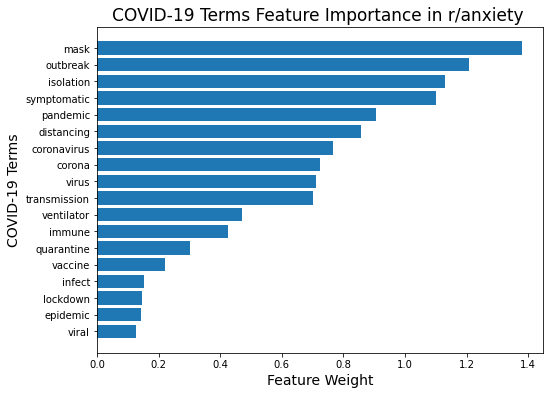

In [120]:
plt.figure(figsize=(8,6))
plt.title('COVID-19 Terms Feature Importance in r/anxiety ', fontsize = 17)
plt.xlabel('Feature Weight', fontsize = 14)
plt.ylabel('COVID-19 Terms', fontsize = 14)

features_names = ['corona', 
                  'virus', 
                  'viral', 
                  'covid', 
                  'pandemic', 
                  'epidemic', 
                  'quarantine', 
                  'lockdown',
                  'distancing',  
                  'infect', 
                  'ventilator', 
                  'mask', 
                  'symptomatic', 
                  'immune', 
                  'transmission', 
                  'vaccine',
                  'coronavirus',
                  'covid-19',
                  'outbreak',
                  'isolation' ]
f_importances(anxiety_classifier.coef_.toarray()[0], features_names)

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


corona
coronavirus
distancing
epidemic
immune
infect
isolation
lockdown
mask
outbreak
pandemic
quarantine
symptomatic
transmission
vaccine
ventilator
viral
virus
Average feature importance: 0.8879905301597818


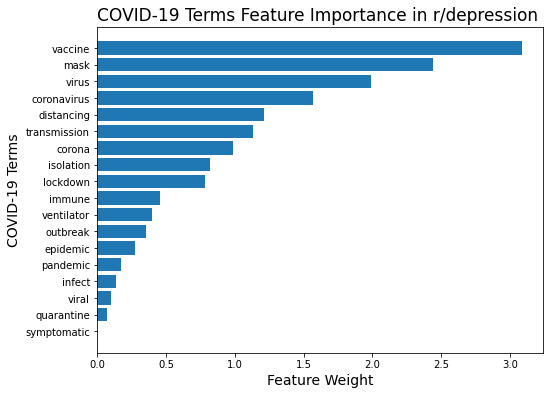

In [134]:
plt.figure(figsize=(8,6))
plt.title('COVID-19 Terms Feature Importance in r/depression ', fontsize = 17)
plt.xlabel('Feature Weight', fontsize = 14)
plt.ylabel('COVID-19 Terms', fontsize = 14)
f_importances(depression_classifier.coef_.toarray()[0], features_names)

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


corona
coronavirus
distancing
epidemic
immune
infect
isolation
lockdown
mask
outbreak
pandemic
quarantine
symptomatic
transmission
vaccine
ventilator
viral
virus
Average feature importance: 0.8143379910498855


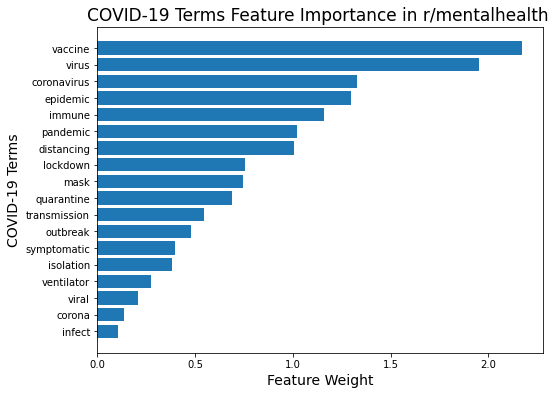

In [147]:
plt.figure(figsize=(8,6))
plt.title('COVID-19 Terms Feature Importance in r/mentalhealth ', fontsize = 17)
plt.xlabel('Feature Weight', fontsize = 14)
plt.ylabel('COVID-19 Terms', fontsize = 14)
f_importances(mentalhealth_classifier.coef_.toarray()[0], features_names)

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


corona
coronavirus
distancing
epidemic
immune
infect
isolation
lockdown
mask
outbreak
pandemic
quarantine
symptomatic
transmission
vaccine
ventilator
viral
virus
Average feature importance: 0.8039164910050193


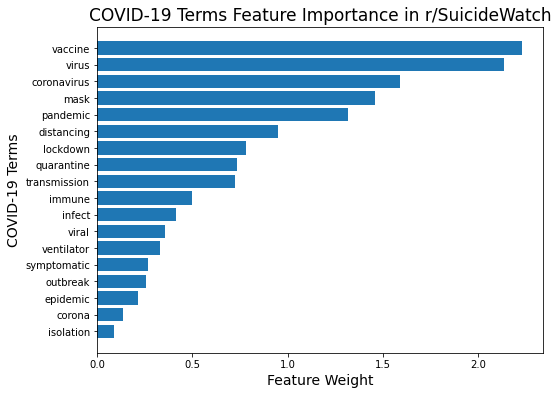

In [160]:
plt.figure(figsize=(8,6))
plt.title('COVID-19 Terms Feature Importance in r/SuicideWatch', fontsize = 17)
plt.xlabel('Feature Weight', fontsize = 14)
plt.ylabel('COVID-19 Terms', fontsize = 14)
f_importances(suicidewatch_classifier.coef_.toarray()[0], features_names)

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


corona
coronavirus
distancing
epidemic
immune
infect
isolation
lockdown
mask
outbreak
pandemic
quarantine
symptomatic
transmission
vaccine
ventilator
viral
virus
Average feature importance: 1.310901414012951


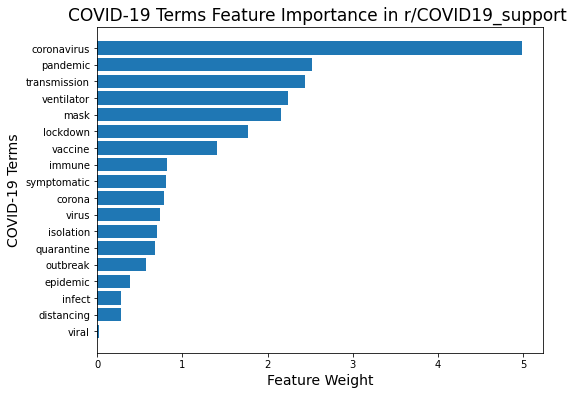

In [173]:
plt.figure(figsize=(8,6))
plt.title('COVID-19 Terms Feature Importance in r/COVID19_support ', fontsize = 17)
plt.xlabel('Feature Weight', fontsize = 14)
plt.ylabel('COVID-19 Terms', fontsize = 14)
f_importances(covid19_support_classifier.coef_.toarray()[0], features_names)

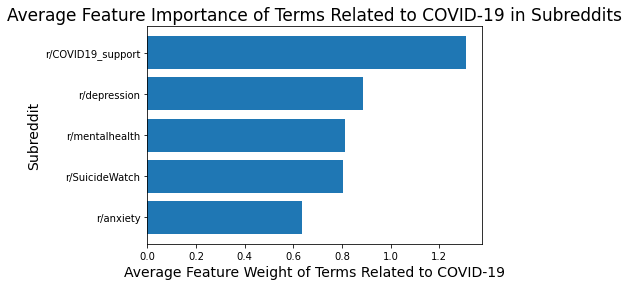

In [3]:
average_dict = {'r/COVID19_support': 1.310901414012951, 'r/SuicideWatch': 0.8039164910050193, 'r/mentalhealth':0.8143379910498855, 'r/depression': 0.8879905301597818, 'r/anxiety': 0.6370239700010649}

names = average_dict.keys()
imp = average_dict.values()
imp,names = zip(*sorted(zip(imp,names)))
plt.barh(range(len(names)), imp, align='center')
plt.yticks(range(len(names)), names)
plt.title('Average Feature Importance of Terms Related to COVID-19 in Subreddits', fontsize = 17)
plt.xlabel('Average Feature Weight of Terms Related to COVID-19', fontsize = 14)
plt.ylabel('Subreddit', fontsize = 14)
plt.show()

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

18312


/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


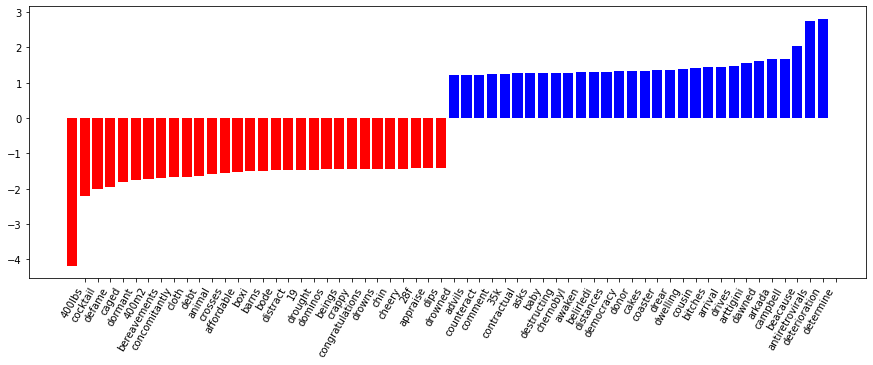

In [49]:
def plot_coefficients(classifier, feature_names, top_features=30):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
cv = CountVectorizer(stop_words = 'english')
cv.fit(train_data.body.to_list())
print (len(cv.vocabulary_))

svm = LinearSVC()
svm.fit(x_train, y_train)

plot_coefficients(svm, cv.get_feature_names())